In [1]:
import ruptures as rpt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

/Users/sondosbsharat/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pandas as pd

In [20]:
df = pd.read_csv('../ready_Data/df_daily_last.csv', parse_dates=['date'])
# df.rename(columns={'published_day':'date'}, inplace=True)


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1908 non-null   datetime64[ns]
 1   date.1                   1908 non-null   object        
 2   close_sp500              1908 non-null   float64       
 3   close_vix                1908 non-null   float64       
 4   polarity_x_strong        1908 non-null   float64       
 5   y                        1908 non-null   float64       
 6   ret_lag1                 1908 non-null   float64       
 7   ret_roll5                1908 non-null   float64       
 8   vix_lag1                 1908 non-null   float64       
 9   vix_chg1                 1908 non-null   float64       
 10  polarity_x_strong_lag1   1908 non-null   float64       
 11  polarity_x_strong_roll3  1908 non-null   float64       
dtypes: datetime64[ns](1), float64(10),

In [22]:
# df['polarity_x_strong'] = df['sent_polarity'] * df['sent_strong']
# 1. Standardize (zero‐mean, unit‐std) each series so neither dominates
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['sent_roll3_std', 'vix_chg1_std']] = scaler.fit_transform(
    df[['polarity_x_strong_roll3', 'vix_chg1']]
)

# 2. Create the interaction (volatility‐weighted sentiment)
df['sent_vix'] = df['sent_roll3_std'] * df['vix_chg1_std']




In [29]:
print(df[['sent_roll3_std','vix_chg1_std']].agg(['mean','std']))


      sent_roll3_std  vix_chg1_std
mean    3.165416e-17 -1.117206e-17
std     1.000262e+00  1.000262e+00


<Axes: >

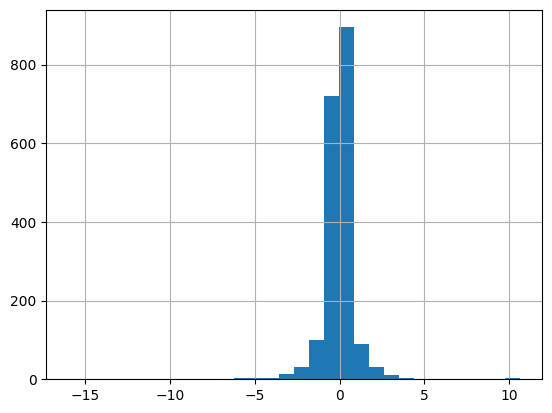

In [30]:
df['sent_vix'].hist(bins=30)


In [31]:
df['roll3_x_sentvix'] = df['polarity_x_strong_roll3'] * df['sent_vix']
df['lag1_x_sentvix']  = df['polarity_x_strong_lag1'] * df['sent_vix']


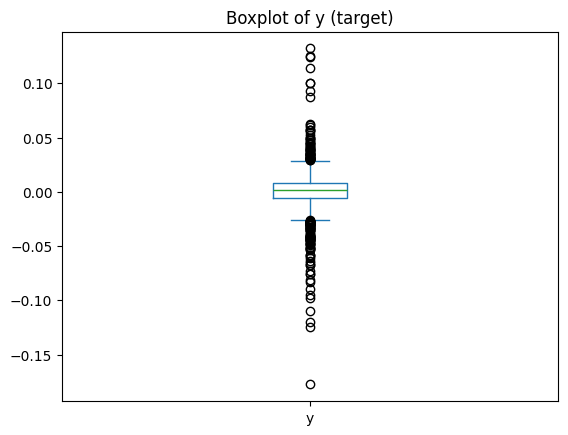

In [23]:
# Basic statistical summary
df.describe()

# Visual check (example for one column)
import matplotlib.pyplot as plt
df['y'].plot(kind='box')
plt.title('Boxplot of y (target)')
plt.show()



In [11]:
df.head()

,title,text,label,date,p_neg,p_neu,p_pos,sent_polarity,sent_strong,sent_weighted,...,ret_lag1,ret_roll5,vix_lag1,polarity_lag1,polarity_roll3,strong_lag1,strong_roll3,polarity_x_strong,polarity_x_strong_lag1,polarity_x_strong_roll3
0,"Travelers are upset about rising costs, but mo...",In this article MAR\n\nMA\n\nEXPE\n\nZETA Foll...,-1,2007-01-31,0.171876,0.006194,8.219296e-01,0.650054,1,0.650054,...,-0.765764,-0.066647,-0.967252,0.481248,1.064968,0.447925,0.760538,0.650054,NaN,NaN
1,What Jeff Bezos told Amazon employees about st...,Although Jeff Bezos announced on Tuesday that ...,0,2007-02-02,0.999699,0.000145,1.562841e-04,-0.999542,-1,-0.999542,...,0.629052,0.157334,-1.072200,1.498050,1.264119,1.989052,1.633251,0.999542,0.650054,NaN
2,Tyson Foods says 91% of workforce is vaccinate...,"More than 90% of Tyson Foods ' 120,000-person ...",-1,2007-02-05,0.999919,0.000020,6.079975e-05,-0.999858,-1,-0.999858,...,0.432081,0.269499,-1.116802,-1.082218,0.509596,-1.093203,0.760538,0.999858,0.999542,NaN
3,Northrop Grumman bows out of the Air Force's $...,The Air Force’s aging T-38 Talon jet trainer i...,0,2007-02-13,0.999680,0.000040,2.800711e-04,-0.999400,-1,-0.999400,...,-0.092353,-0.202315,-1.055146,-1.082711,-0.379617,-1.093203,-0.112176,0.999400,0.999858,0.883151
4,Northrop Grumman to buy missile maker Orbital ...,Defense contractor Northrop Grumman said Monda...,2,2007-02-14,0.000402,0.999598,7.202638e-08,-0.000402,0,-0.000402,...,-0.152487,0.017523,-1.082694,-1.081995,-1.846542,-1.093203,-1.857604,-0.000000,0.999400,0.999600


In [ ]:
# df['polarity_x_strong_lag1'] = df['polarity_lag1'] * df['strong_lag1']
# df['polarity_x_strong_roll3'] = df['polarity_roll3'] * df['strong_roll3']

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1908 non-null   datetime64[ns]
 1   date.1                   1908 non-null   object        
 2   close_sp500              1908 non-null   float64       
 3   close_vix                1908 non-null   float64       
 4   polarity_x_strong        1908 non-null   float64       
 5   y                        1908 non-null   float64       
 6   ret_lag1                 1908 non-null   float64       
 7   ret_roll5                1908 non-null   float64       
 8   vix_lag1                 1908 non-null   float64       
 9   vix_chg1                 1908 non-null   float64       
 10  polarity_x_strong_lag1   1908 non-null   float64       
 11  polarity_x_strong_roll3  1908 non-null   float64       
 12  sent_roll3_std           1908 non-

In [32]:
feature_cols = [
  'ret_lag1','ret_roll5','vix_lag1','vix_chg1',
  'polarity_x_strong_lag1','polarity_x_strong_roll3',
  'sent_vix','roll3_x_sentvix','lag1_x_sentvix'
]


In [23]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install xgboost 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


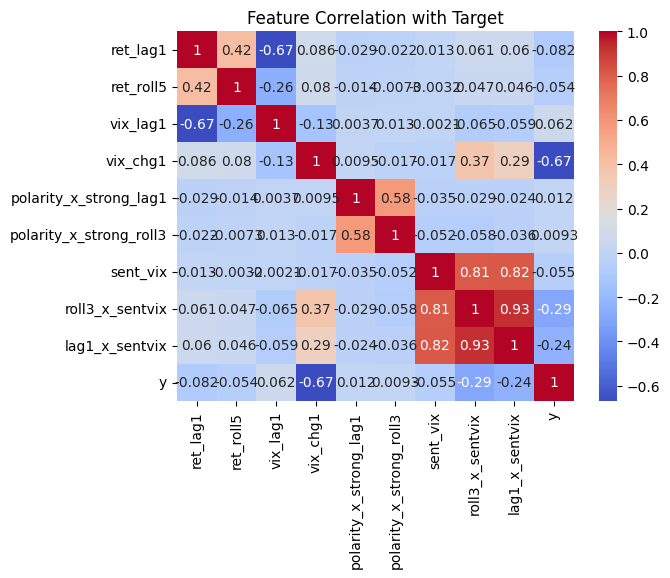

In [33]:
# Visualize correlations
sns.heatmap(df[feature_cols + ['y']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Target")
plt.show()


In [34]:
import pandas as pd
import itertools
from sklearn.preprocessing import StandardScaler

# 1. Select and standardize your predictors (so no one feature dominates)
feature_cols = [
    'ret_lag1','ret_roll5','vix_lag1','vix_chg1',
    'polarity_x_strong_lag1','polarity_x_strong_roll3','sent_vix'
]
scaler = StandardScaler()
X_std = pd.DataFrame(
    scaler.fit_transform(df[feature_cols]),
    index=df.index,
    columns=feature_cols
)

# 2. Build all pairwise interaction features
interactions = {}
for f1, f2 in itertools.combinations(feature_cols, 2):
    interactions[f"{f1}_x_{f2}"] = X_std[f1] * X_std[f2]
df_inter = pd.DataFrame(interactions, index=df.index)

# 3. Rank interactions by absolute correlation with target y
corrs = df_inter.corrwith(df['y']).abs().sort_values(ascending=False)
print("Top 5 candidate interactions:")
print(corrs.head(5))


Top 5 candidate interactions:
polarity_x_strong_roll3_x_sent_vix    0.425699
ret_roll5_x_vix_chg1                  0.413845
polarity_x_strong_lag1_x_sent_vix     0.344395
ret_lag1_x_vix_chg1                   0.275260
vix_lag1_x_vix_chg1                   0.162848
dtype: float64


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
feature_cols = [
  'ret_lag1','ret_roll5','vix_lag1','vix_chg1',
  'polarity_x_strong_lag1','polarity_x_strong_roll3',
  'sent_vix','roll3_x_sentvix','lag1_x_sentvix'
]

for col in feature_cols:
    X = df[[col]].fillna(0)
    y = (df['y'] > 0).astype(int)  # Assuming binary movement target
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
    
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    print(f"{col}: AUC = {auc:.3f}")


ret_lag1: AUC = 0.515
ret_roll5: AUC = 0.527
vix_lag1: AUC = 0.489
vix_chg1: AUC = 0.867
polarity_x_strong_lag1: AUC = 0.476
polarity_x_strong_roll3: AUC = 0.507
sent_vix: AUC = 0.463
roll3_x_sentvix: AUC = 0.503
lag1_x_sentvix: AUC = 0.551


In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import grangercausalitytests

# 1. Build the 14-day rolling mean and EWMA
df['sent_14d']  = df['polarity_x_strong'].rolling(14, min_periods=7).mean()
df['sent_ewma'] = df['polarity_x_strong'].ewm(span=14).mean()

# 2. (Optional) Standardize them if you care about scale later
scaler = StandardScaler()
df[['sent_14d_std','sent_ewma_std']] = scaler.fit_transform(
    df[['sent_14d','sent_ewma']].fillna(0)
)

# 3. Create the 1-day ahead target and drop NAs
df['y_next'] = df['y'].shift(-1)
sub = df[['sent_14d','sent_ewma','sent_14d_std','sent_ewma_std','y_next']].dropna()

# 4. Pearson correlation
for col in ['sent_14d','sent_ewma']:
    r = sub[[col,'y_next']].corr().iloc[0,1]
    print(f"{col:8s} Pearson r = {r:.3f}")

# 5. Directional AUC
y_bin = (sub['y_next'] > 0).astype(int)
for col in ['sent_14d','sent_ewma']:
    X = sub[[col]]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_bin, shuffle=False, test_size=0.3
    )
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]
    print(f"{col:8s} AUC = {roc_auc_score(y_test, y_pred):.3f}")

# 6. Granger causality (maxlag=7)
print("\nGranger causality tests (y_next ~ sent_ewma):")
grangercausalitytests(sub[['y_next','sent_ewma']], maxlag=7, verbose=True)

sent_14d Pearson r = 0.027
sent_ewma Pearson r = 0.020
sent_14d AUC = 0.495
sent_ewma AUC = 0.514

Granger causality tests (y_next ~ sent_ewma):


/Users/sondosbsharat/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5659  , p=0.4520  , df_denom=1897, df_num=1
ssr based chi2 test:   chi2=0.5668  , p=0.4515  , df=1
likelihood ratio test: chi2=0.5667  , p=0.4516  , df=1
parameter F test:         F=0.5659  , p=0.4520  , df_denom=1897, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5014  , p=0.2231  , df_denom=1894, df_num=2
ssr based chi2 test:   chi2=3.0107  , p=0.2219  , df=2
likelihood ratio test: chi2=3.0083  , p=0.2222  , df=2
parameter F test:         F=1.5014  , p=0.2231  , df_denom=1894, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0541  , p=0.3676  , df_denom=1891, df_num=3
ssr based chi2 test:   chi2=3.1739  , p=0.3656  , df=3
likelihood ratio test: chi2=3.1713  , p=0.3660  , df=3
parameter F test:         F=1.0541  , p=0.3676  , df_denom=1891, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1167  , p=0.

{1: ({'ssr_ftest': (0.5658813552504631, 0.45199354088566546, 1897.0, 1),
   'ssr_chi2test': (0.5667762651427939, 0.4515427939602552, 1),
   'lrtest': (0.5666917463386199, 0.45157653116121843, 1),
   'params_ftest': (0.5658813552517694, 0.45199354088507615, 1897.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.5013733554656081, 0.22308900232926143, 1894.0, 2),
   'ssr_chi2test': (3.0106737085841497, 0.2219425189484347, 2),
   'lrtest': (3.0082896676794917, 0.22220723671341244, 2),
   'params_ftest': (1.5013733554648128, 0.22308900232941958, 1894.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.0540669630357908, 0.3675504000329932, 1891.0, 3),
   'ssr_chi2test': (3.17390655078043, 0.36558155053325964, 3),
   'lrtest': (3.1712557429691515, 0.3659670976351203, 3),
   'params_ftest': (1.054066963036102, 0.36755040003292144, 1891.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics    import roc_auc_score
from sklearn.model_selection import train_test_split

# Ensure these columns exist:
# df['roll3_x_sentvix'] = df['polarity_x_strong_roll3'] * df['sent_vix']
# df['lag1_x_sentvix']  = df['polarity_x_strong_lag1']  * df['sent_vix']

for col in ['roll3_x_sentvix','lag1_x_sentvix']:
    r = df[[col,'y_next']].dropna().corr().iloc[0,1]
    print(f"{col:16s} Pearson r = {r:.3f}")

    X = df[[col]].fillna(0)
    y = (df['y_next'] > 0).astype(int)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, shuffle=False, test_size=0.3)
    auc = roc_auc_score(y_te, LogisticRegression().fit(X_tr,y_tr).predict_proba(X_te)[:,1])
    print(f"{col:16s} AUC = {auc:.3f}\n")


roll3_x_sentvix  Pearson r = -0.021
roll3_x_sentvix  AUC = 0.464

lag1_x_sentvix   Pearson r = -0.041
lag1_x_sentvix   AUC = 0.472



In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics    import roc_auc_score

for col in ['roll3_x_sentvix','lag1_x_sentvix']:
    X = df[[col]].fillna(0)
    y = (df['y_next'] > 0).astype(int)
    model = LogisticRegression().fit(X, y)
    auc = roc_auc_score(y, model.predict_proba(X)[:,1])
    print(f"{col}: AUC = {auc:.3f}")


roll3_x_sentvix: AUC = 0.508
lag1_x_sentvix: AUC = 0.510


In [42]:
# define high-vol subset
thr = df['vix_chg1_std'].quantile(0.75)
hi_vol = df['vix_chg1_std'] >= thr

for col in ['roll3_x_sentvix','lag1_x_sentvix']:
    X = df.loc[hi_vol, [col]].fillna(0)
    y = (df.loc[hi_vol, 'y_next'] > 0).astype(int)
    if len(X) < 50:
        print(col, "– not enough high-vol days to test")
        continue

    model = LogisticRegression().fit(X, y)
    auc = roc_auc_score(y, model.predict_proba(X)[:,1])
    print(f"{col:16s} High-vol AUC = {auc:.3f}")


roll3_x_sentvix  High-vol AUC = 0.510
lag1_x_sentvix   High-vol AUC = 0.529


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics    import roc_auc_score

base = ['vix_chg1_std']
for extra in ['roll3_x_sentvix','lag1_x_sentvix']:
    X = df[base + [extra]].fillna(0)
    y = (df['y_next'] > 0).astype(int)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, shuffle=False, test_size=0.3)

    base_auc = roc_auc_score(y_te, LogisticRegression().fit(X_tr[base], y_tr).predict_proba(X_te[base])[:,1])
    new_auc  = roc_auc_score(y_te, LogisticRegression().fit(X_tr, y_tr).predict_proba(X_te)[:,1])
    print(f"Add {extra:16s} → AUC: {base_auc:.3f} → {new_auc:.3f} (Δ {new_auc-base_auc:+.3f})")


Add roll3_x_sentvix  → AUC: 0.488 → 0.477 (Δ -0.011)
Add lag1_x_sentvix   → AUC: 0.488 → 0.485 (Δ -0.003)


check whoch variations to use 

In [44]:
from sklearn.preprocessing import StandardScaler

# 1. Prepare your base series
df['sent_ewma'] = df['polarity_x_strong'].ewm(span=14).mean().fillna(0)

# 2. Standardize both
scaler = StandardScaler()
df[['sent_ewma_std','vix_chg1_std']] = scaler.fit_transform(
    df[['sent_ewma','vix_chg1']].fillna(0)
)

# 3. Flag extreme volatility (e.g. top 20%)
thr = df['vix_chg1_std'].quantile(0.80)
df['high_vol'] = (df['vix_chg1_std'] >= thr).astype(int)

# 4. Split positive/negative sentiment
df['sent_pos'] = df['sent_ewma_std'].clip(lower=0)
df['sent_neg'] = (-df['sent_ewma_std'].clip(upper=0))

# 5. Create regime-conditioned features
df['pos_hivol'] = df['sent_pos'] * df['high_vol']
df['neg_hivol'] = df['sent_neg'] * df['high_vol']

# 6. Quick AUC check
from sklearn.linear_model import LogisticRegression
from sklearn.metrics    import roc_auc_score

for col in ['pos_hivol','neg_hivol']:
    X = df[[col]].fillna(0)
    y = (df['y_next'] > 0).astype(int)
    model = LogisticRegression().fit(X, y)
    print(f"{col:10s} AUC = {roc_auc_score(y, model.predict_proba(X)[:,1]):.3f}")


pos_hivol  AUC = 0.507
neg_hivol  AUC = 0.502


In [9]:
df['sent_shift'] = df['polarity_x_strong_roll3'].diff().abs()
df['sent_cp'] = df['sent_shift'] > df['sent_shift'].quantile(0.9)

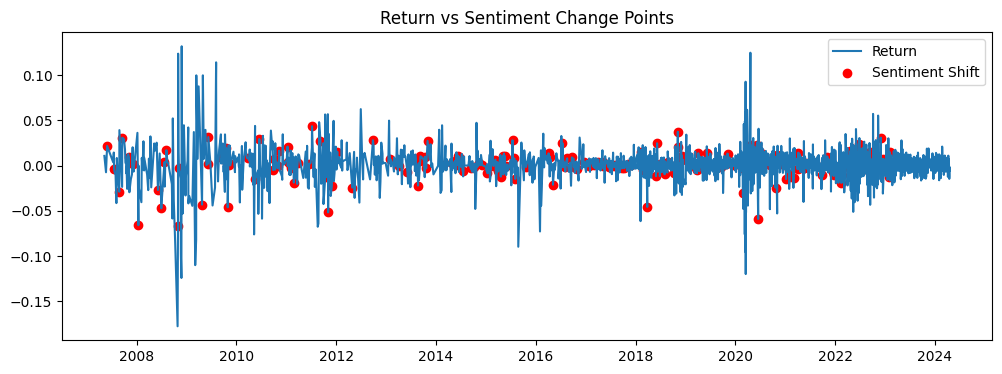

In [10]:
df['polarity_x_strong_lag1'] = df['polarity_x_strong_roll3'].diff().abs()
df['sent_cp'] = df['sent_shift'] > df['sent_shift'].quantile(0.9)

plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['ret_lag1'], label='Return')
plt.scatter(df.loc[df['sent_cp'], 'date'], df.loc[df['sent_cp'], 'ret_lag1'], color='red', label='Sentiment Shift')
plt.legend()
plt.title("Return vs Sentiment Change Points")
plt.show()


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1908 non-null   datetime64[ns]
 1   date.1                   1908 non-null   object        
 2   close_sp500              1908 non-null   float64       
 3   close_vix                1908 non-null   float64       
 4   polarity_x_strong        1908 non-null   float64       
 5   y                        1908 non-null   float64       
 6   ret_lag1                 1908 non-null   float64       
 7   ret_roll5                1908 non-null   float64       
 8   vix_lag1                 1908 non-null   float64       
 9   vix_chg1                 1908 non-null   float64       
 10  polarity_x_strong_lag1   1907 non-null   float64       
 11  polarity_x_strong_roll3  1908 non-null   float64       
 12  sent_shift               1907 non-

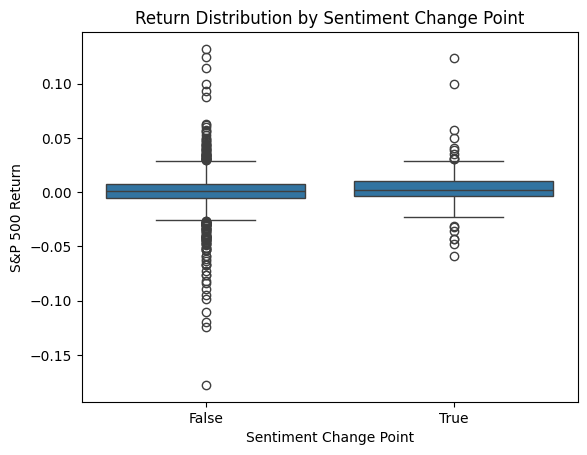

In [13]:
import seaborn as sns
sns.boxplot(x=df['sent_cp'], y=df['y'])
plt.title("Return Distribution by Sentiment Change Point")
plt.xlabel("Sentiment Change Point")
plt.ylabel("S&P 500 Return")
plt.show()

In [ ]:
df.head()

,Unnamed: 0,title,text,label,date,p_neg,p_neu,p_pos,sent_polarity,sent_strong,...,vix_lag1,polarity_lag1,polarity_roll3,strong_lag1,strong_roll3,polarity_x_strong,polarity_x_strong_lag1,polarity_x_strong_roll3,sent_shift,sent_cp
0,0,Black Friday Could Boost These Discounters: CEO,"During the last couple of years, the discount ...",0,2007-04-09,4.881313e-01,0.017258,4.946107e-01,6.479353e-03,0,...,-1.098478,0.480373,-0.957997,0.44787,-0.984876,0.000000,NaN,0.943508,NaN,False
1,1,Traders discuss if Amazon and Alphabet shares ...,As Amazon and Google-parent Alphabet shares co...,0,2007-04-16,7.801456e-05,0.999922,1.626571e-07,-7.785190e-05,0,...,-0.716703,0.491137,-0.062855,0.44787,-0.111923,-0.000000,0.936474,0.007035,0.936474,False
2,2,Stocks making the biggest moves in the premark...,Take a look at some of the biggest movers in t...,-1,2007-04-16,1.099502e-06,0.999995,4.093828e-06,2.994326e-06,0,...,-0.868889,0.480879,0.826047,0.44787,0.761031,0.000000,0.621612,0.628647,0.621612,False
3,3,Amazon or Alphabet? Traders debate which is th...,"The ""Fast Money"" traders debated which stock i...",0,2007-04-19,3.059629e-07,1.000000,1.037473e-08,-2.955882e-07,0,...,-0.868889,0.481006,0.826407,0.44787,0.761031,-0.000000,0.000274,0.628921,0.000274,False
4,4,"Lightning Round: Skyworks Solutions, AT&T, Ann...",Liquidity Services : Jim Cramer would like to ...,0,2007-04-30,9.990477e-01,0.000003,9.496869e-04,-9.980980e-01,-1,...,-0.795420,0.481001,0.820643,0.44787,0.761031,0.998098,0.004386,0.624535,0.004386,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ret_lag1                 1908 non-null   float64
 1   ret_roll5                1908 non-null   float64
 2   vix_lag1                 1908 non-null   float64
 3   vix_chg1                 1908 non-null   float64
 4   polarity_x_strong_lag1   1907 non-null   float64
 5   polarity_x_strong_roll3  1908 non-null   float64
 6   y                        1908 non-null   float64
dtypes: float64(7)
memory usage: 104.5 KB
None
          ret_lag1    ret_roll5     vix_lag1     vix_chg1  \
count  1908.000000  1908.000000  1908.000000  1908.000000   
mean      0.000806     0.000816     0.006232     0.006269   
std       0.018310     0.007213     0.121089     0.121088   
min      -0.177600    -0.062795    -0.403609    -0.403609   
25%      -0.005404    -0.001834    -0.051434    -0.05143

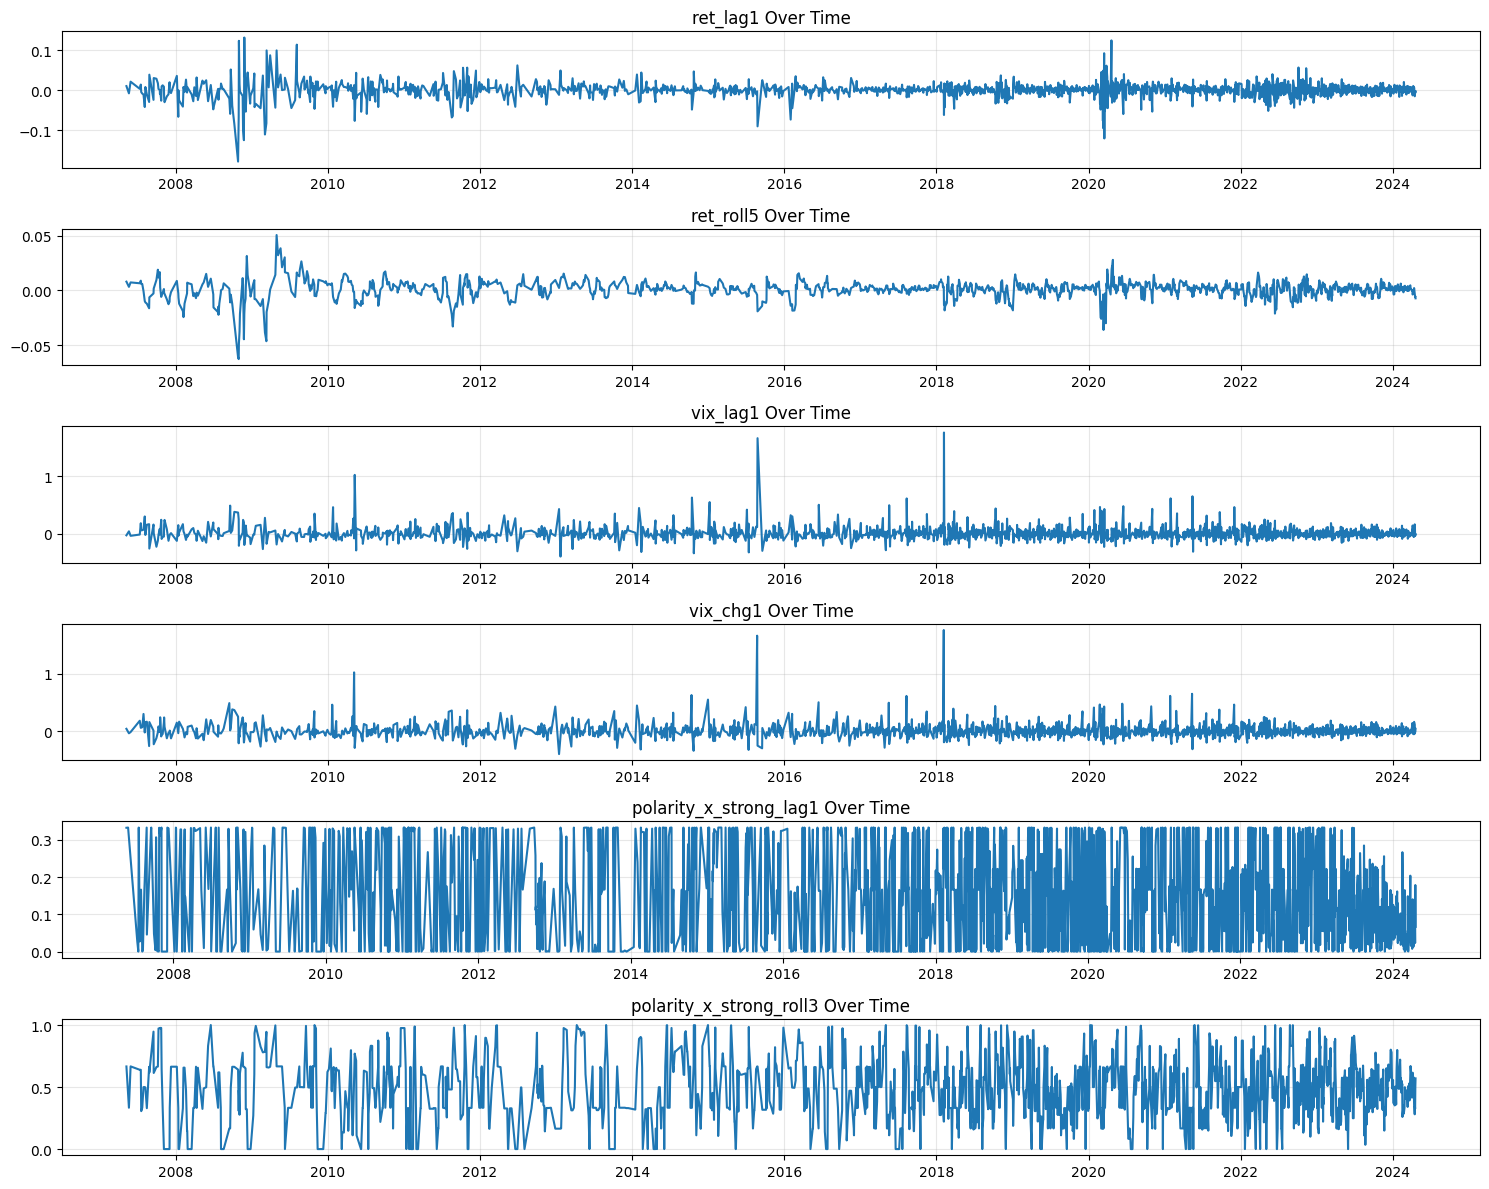

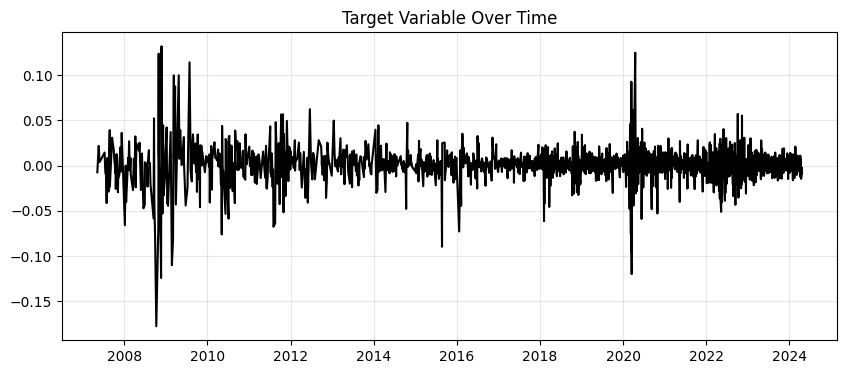

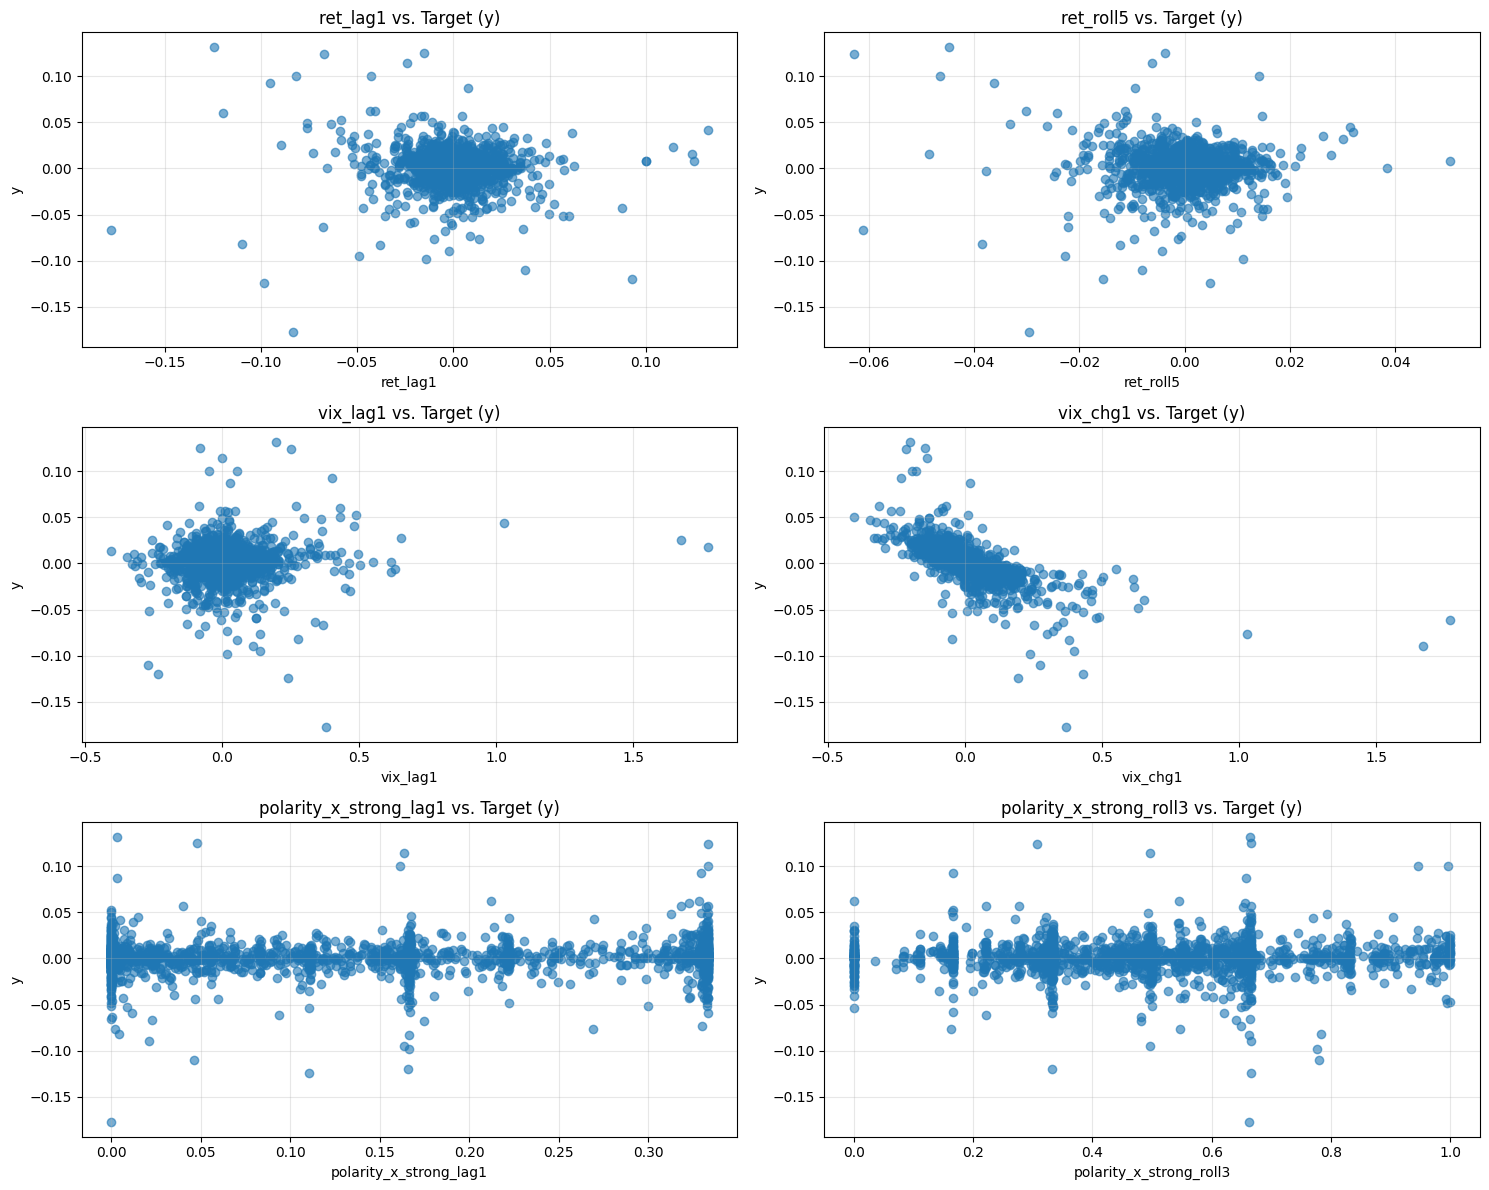

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Define your features and target
feature_cols = ['ret_lag1', 'ret_roll5', 'vix_lag1', 'vix_chg1', 
                'polarity_x_strong_lag1', 'polarity_x_strong_roll3']

# Check the basic info of the data
print(df[feature_cols + ['y']].info())
print(df[feature_cols + ['y']].describe())

# 1. Plot each feature over time
plt.figure(figsize=(15, 12))
for i, col in enumerate(feature_cols):
    plt.subplot(len(feature_cols), 1, i + 1)
    plt.plot(df['date'], df[col])
    plt.title(f'{col} Over Time')
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Plot the target over time
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['y'], label='Target (y)', color='black')
plt.title('Target Variable Over Time')
plt.grid(alpha=0.3)
plt.show()

# 3. Scatter plots: each feature vs. target
plt.figure(figsize=(15, 12))
for i, col in enumerate(feature_cols):
    plt.subplot(3, 2, i + 1)
    plt.scatter(df[col], df['y'], alpha=0.6)
    plt.title(f'{col} vs. Target (y)')
    plt.xlabel(col)
    plt.ylabel('y')
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1908 non-null   datetime64[ns]
 1   date.1                   1908 non-null   object        
 2   close_sp500              1908 non-null   float64       
 3   close_vix                1908 non-null   float64       
 4   polarity_x_strong        1908 non-null   float64       
 5   y                        1908 non-null   float64       
 6   ret_lag1                 1908 non-null   float64       
 7   ret_roll5                1908 non-null   float64       
 8   vix_lag1                 1908 non-null   float64       
 9   vix_chg1                 1908 non-null   float64       
 10  polarity_x_strong_lag1   1907 non-null   float64       
 11  polarity_x_strong_roll3  1908 non-null   float64       
 12  sent_shift               1907 non-

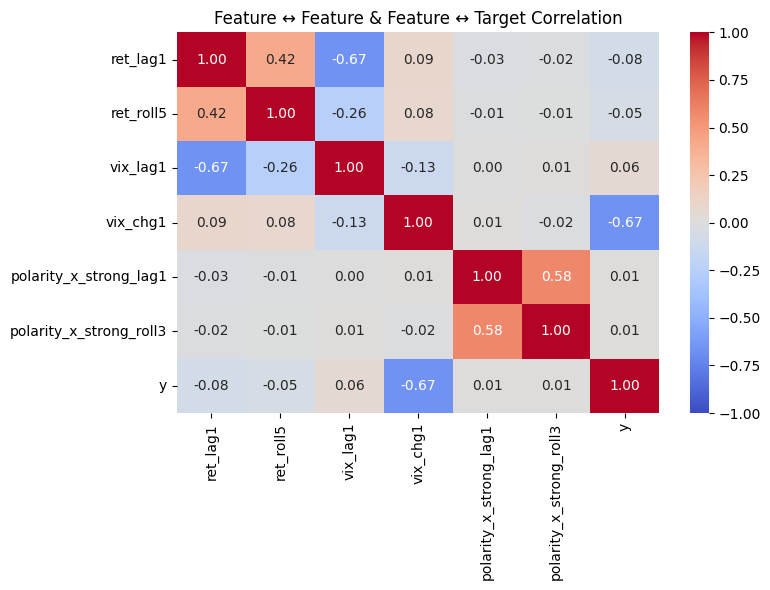

Mutual Information Scores (higher ⇒ more dependence):
 vix_chg1                   0.472024
ret_lag1                   0.060480
ret_roll5                  0.054120
vix_lag1                   0.028682
polarity_x_strong_lag1     0.008646
polarity_x_strong_roll3    0.000503
dtype: float64 



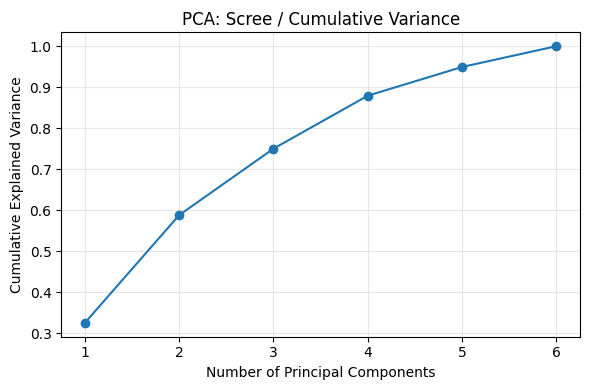

Explained Variance Ratio by PC:
 PC1    0.325556
PC2    0.262659
PC3    0.161956
PC4    0.129146
PC5    0.069983
PC6    0.050700
dtype: float64 

Linear Regression Performance on TEST SET:
  MAE  = 0.0060
  RMSE = 0.0085
  R²   = 0.4099

Learned Coefficients:
 ret_lag1                  -0.078801
ret_roll5                  0.040125
vix_lag1                  -0.010700
vix_chg1                  -0.100520
polarity_x_strong_lag1     0.001502
polarity_x_strong_roll3   -0.001682
dtype: float64


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─── 1) DEFINE FEATURES & TARGET ────────────────────────────────────────
feature_cols = [
    'ret_lag1','ret_roll5','vix_lag1','vix_chg1',
    'polarity_x_strong_lag1','polarity_x_strong_roll3'
]
X = df[feature_cols]
y = df['y']

# ─── 2) CORRELATION MATRIX ─────────────────────────────────────────────
corr = df[feature_cols + ['y']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature ↔ Feature & Feature ↔ Target Correlation")
plt.tight_layout()
plt.show()

# ─── 3) MUTUAL INFORMATION ─────────────────────────────────────────────
mi = mutual_info_regression(X, y, random_state=0)
mi_series = pd.Series(mi, index=feature_cols).sort_values(ascending=False)
print("Mutual Information Scores (higher ⇒ more dependence):\n", mi_series, "\n")

# ─── 4) PCA ─────────────────────────────────────────────────────────────
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Scree / cumulative variance plot
cumvar = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Scree / Cumulative Variance")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print explained variance ratios
evr = pca.explained_variance_ratio_
pc_labels = [f"PC{i}" for i in range(1, len(evr)+1)]
evr_series = pd.Series(evr, index=pc_labels)
print("Explained Variance Ratio by PC:\n", evr_series, "\n")

# ─── 5) BASELINE LINEAR REGRESSION ─────────────────────────────────────
# Chronological split (no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae   = mean_absolute_error(y_test, y_pred)
rmse  = np.sqrt(mean_squared_error(y_test, y_pred))
r2    = r2_score(y_test, y_pred)

print("Linear Regression Performance on TEST SET:")
print(f"  MAE  = {mae:.4f}")
print(f"  RMSE = {rmse:.4f}")
print(f"  R²   = {r2:.4f}\n")

# Coefficients
coef_series = pd.Series(lr.coef_, index=feature_cols)
print("Learned Coefficients:\n", coef_series)


Signs & magnitudes

Economic features (ret_*, vix_*) have small positive weights, indicating “higher past returns/volatility → very slightly higher next‐day return.”

Sentiment features have small negative weights here—suggesting that stronger news polarity (lagged or rolling) is weakly associated with lower next‐day returns in a linear sense.

Scale caveat

Because your features aren’t standardized, direct coefficient magnitudes mix units (e.g. % return vs. polarity score). The take-away is that none of these features has a large linear effect on y

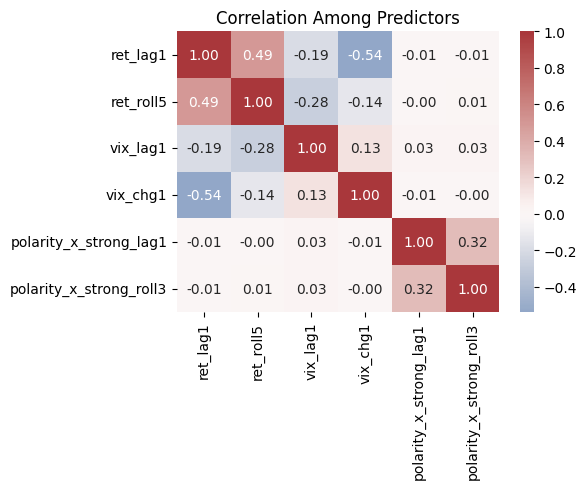

Highly correlated feature pairs (|corr| > 0.8):
 Series([], dtype: float64) 



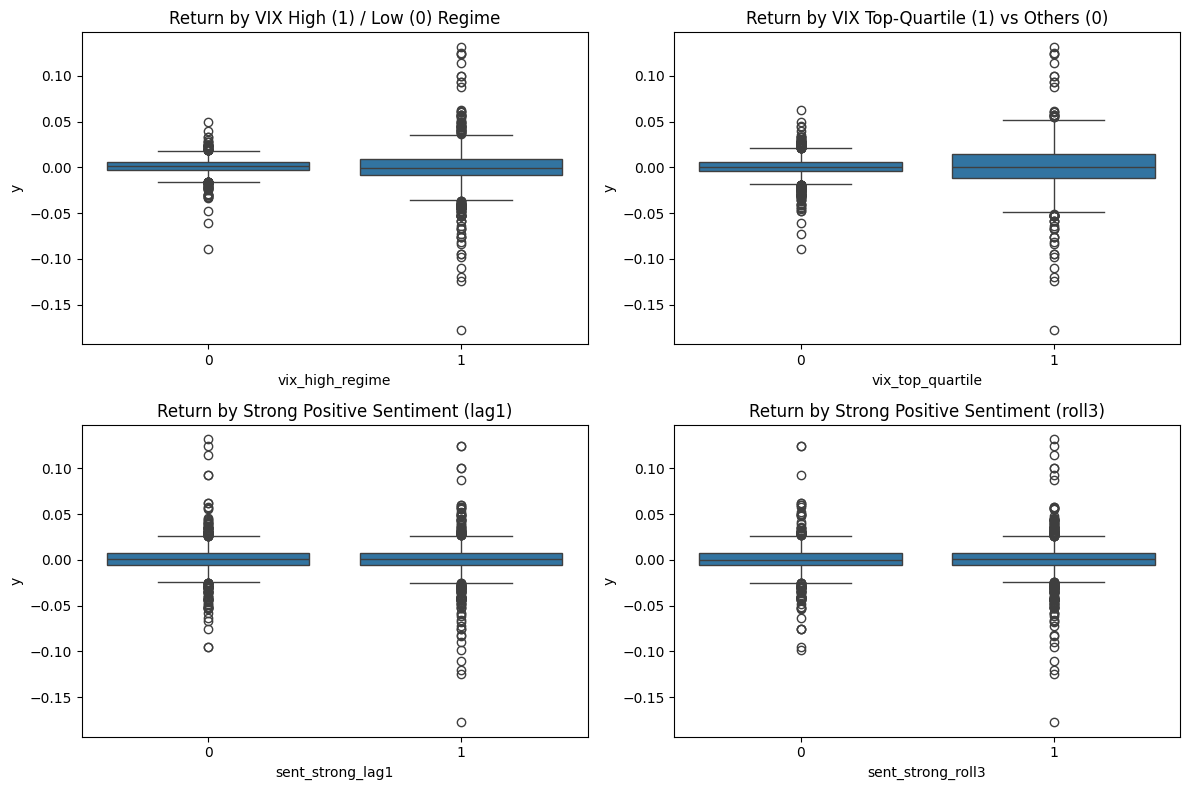

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ─── 1) CORRELATION AMONG ORIGINAL FEATURES ─────────────────────────────
feature_cols = [
    'ret_lag1','ret_roll5','vix_lag1','vix_chg1',
    'polarity_x_strong_lag1','polarity_x_strong_roll3'
]

corr_feats = df[feature_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_feats, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation Among Predictors")
plt.tight_layout()
plt.show()

# List any pairs with |corr| > 0.8
high_corr = (
    corr_feats
    .where(np.triu(np.ones(corr_feats.shape), k=1).astype(bool))
    .stack()
    .loc[lambda s: s.abs() > 0.8]
)
print("Highly correlated feature pairs (|corr| > 0.8):\n", high_corr, "\n")

# ─── 2) VOLATILITY REGIME FEATURES ──────────────────────────────────────
# flag days of high vs low volatility
vix_med = df['vix_lag1'].median()
df['vix_high_regime'] = (df['vix_lag1'] > vix_med).astype(int)

q75 = df['vix_lag1'].quantile(0.75)
df['vix_top_quartile'] = (df['vix_lag1'] >= q75).astype(int)

# ─── 3) SENTIMENT THRESHOLD FEATURES ──────────────────────────────────
# pick a threshold for "strong" sentiment
th = 0.5

df['sent_strong_lag1'] = (df['polarity_x_strong_lag1'] >= th).astype(int)
df['sent_strong_roll3'] = (df['polarity_x_strong_roll3'] >= th).astype(int)

# If you also want strong negative:
df['sent_strong_neg_lag1'] = (df['polarity_x_strong_lag1'] <= -th).astype(int)
df['sent_strong_neg_roll3'] = (df['polarity_x_strong_roll3'] <= -th).astype(int)

# Drop any rows with NAs in features or the target
df_fe = df.dropna(subset=feature_cols + 
                  ['vix_high_regime','vix_top_quartile',
                   'sent_strong_lag1','sent_strong_roll3',
                   'sent_strong_neg_lag1','sent_strong_neg_roll3','y'])

# ─── 4) VISUALIZE NEW BINARY FEATURES vs. TARGET ────────────────────────
plt.figure(figsize=(12, 8))

# VIX high/low regime
plt.subplot(2,2,1)
sns.boxplot(x='vix_high_regime', y='y', data=df_fe)
plt.title('Return by VIX High (1) / Low (0) Regime')

# VIX top quartile
plt.subplot(2,2,2)
sns.boxplot(x='vix_top_quartile', y='y', data=df_fe)
plt.title('Return by VIX Top‐Quartile (1) vs Others (0)')

# Strong positive sentiment (lag1)
plt.subplot(2,2,3)
sns.boxplot(x='sent_strong_lag1', y='y', data=df_fe)
plt.title('Return by Strong Positive Sentiment (lag1)')

# Strong positive sentiment (roll3)
plt.subplot(2,2,4)
sns.boxplot(x='sent_strong_roll3', y='y', data=df_fe)
plt.title('Return by Strong Positive Sentiment (roll3)')

plt.tight_layout()
plt.show()


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# make sure df_fe exists (i.e. you ran the feature-engineering snippet before)
# original 6 features
orig_feats = [
    'ret_lag1','ret_roll5','vix_lag1','vix_chg1',
    'polarity_x_strong_lag1','polarity_x_strong_roll3'
]

# expanded with regime & threshold flags
eng_feats = orig_feats + [
    'vix_high_regime','vix_top_quartile',
    'sent_strong_lag1','sent_strong_neg_lag1',
    'sent_strong_roll3','sent_strong_neg_roll3'
]

def evaluate_features(features, df):
    X = df[features]
    y = df['y']
    # chronological split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    lr = LinearRegression().fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))   # <-- no squared= keyword
    r2   = r2_score(y_test, y_pred)

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

results = {
    'Original 6 features': evaluate_features(orig_feats, df_fe),
    'With engineered regimes': evaluate_features(eng_feats, df_fe)
}

import pprint
pprint.pprint(results)


{'Original 6 features': {'MAE': 0.0052600899547146415,
                         'R2': 0.032551337069985586,
                         'RMSE': 0.006600628199421892},
 'With engineered regimes': {'MAE': 0.005146405430202294,
                             'R2': 0.07133209795612161,
                             'RMSE': 0.006466980086693933}}


In [44]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_test = y_test  # your true returns on test set
y_zero = np.zeros_like(y_test)

baseline_mae  = mean_absolute_error(y_test, y_zero)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_zero))
print(f"Baseline (zero‐return) MAE:  {baseline_mae:.4f}")
print(f"Baseline (zero‐return) RMSE: {baseline_rmse:.4f}")


Baseline (zero‐return) MAE:  0.0054
Baseline (zero‐return) RMSE: 0.0067


In [45]:
print("Median |return|:", np.median(np.abs(y_test)))
print("75th pctile |return|:", np.percentile(np.abs(y_test), 75))


Median |return|: 0.0045993575202152
75th pctile |return|: 0.00824145796339


In [48]:
n_articles = df.shape[0]                          # 4170
n_dates    = df['date'].nunique()                 # e.g. ~1000–1100, depending on span
print(f"Articles: {n_articles}, Unique dates: {n_dates}")


Articles: 4165, Unique dates: date    1914
date    1914
dtype: int64


In [51]:
# First, ensure 'date' is a single, proper column
if 'date' in df.columns:
    print("Date column found.")
else:
    print("No column named 'date' — check column names:")
    print(df.columns)

# Check for duplicated column names
print("Duplicated columns:", df.columns[df.columns.duplicated()].tolist())

# Drop duplicate 'date' columns if necessary (keep the first one)
df = df.loc[:, ~df.columns.duplicated()]

Date column found.
Duplicated columns: ['date']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4165 entries, 0 to 4164
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ret_lag1                 4165 non-null   float64
 1   ret_roll5                4165 non-null   float64
 2   vix_lag1                 4165 non-null   float64
 3   vix_chg1                 4165 non-null   float64
 4   polarity_x_strong_lag1   4165 non-null   float64
 5   polarity_x_strong_roll3  4165 non-null   float64
 6   y                        4165 non-null   float64
dtypes: float64(7)
memory usage: 227.9 KB
None
           ret_lag1     ret_roll5      vix_lag1      vix_chg1  \
count  4.165000e+03  4.165000e+03  4.165000e+03  4.165000e+03   
mean  -1.705985e-17 -6.823940e-18  1.296549e-16  3.753167e-17   
std    1.000120e+00  1.000120e+00  1.000120e+00  1.000120e+00   
min   -1.163168e+01 -7.404603e+00 -1.241480e+00 -4.948467e+00   
25%   -3.966073e-01 -4.685743e-01 -6

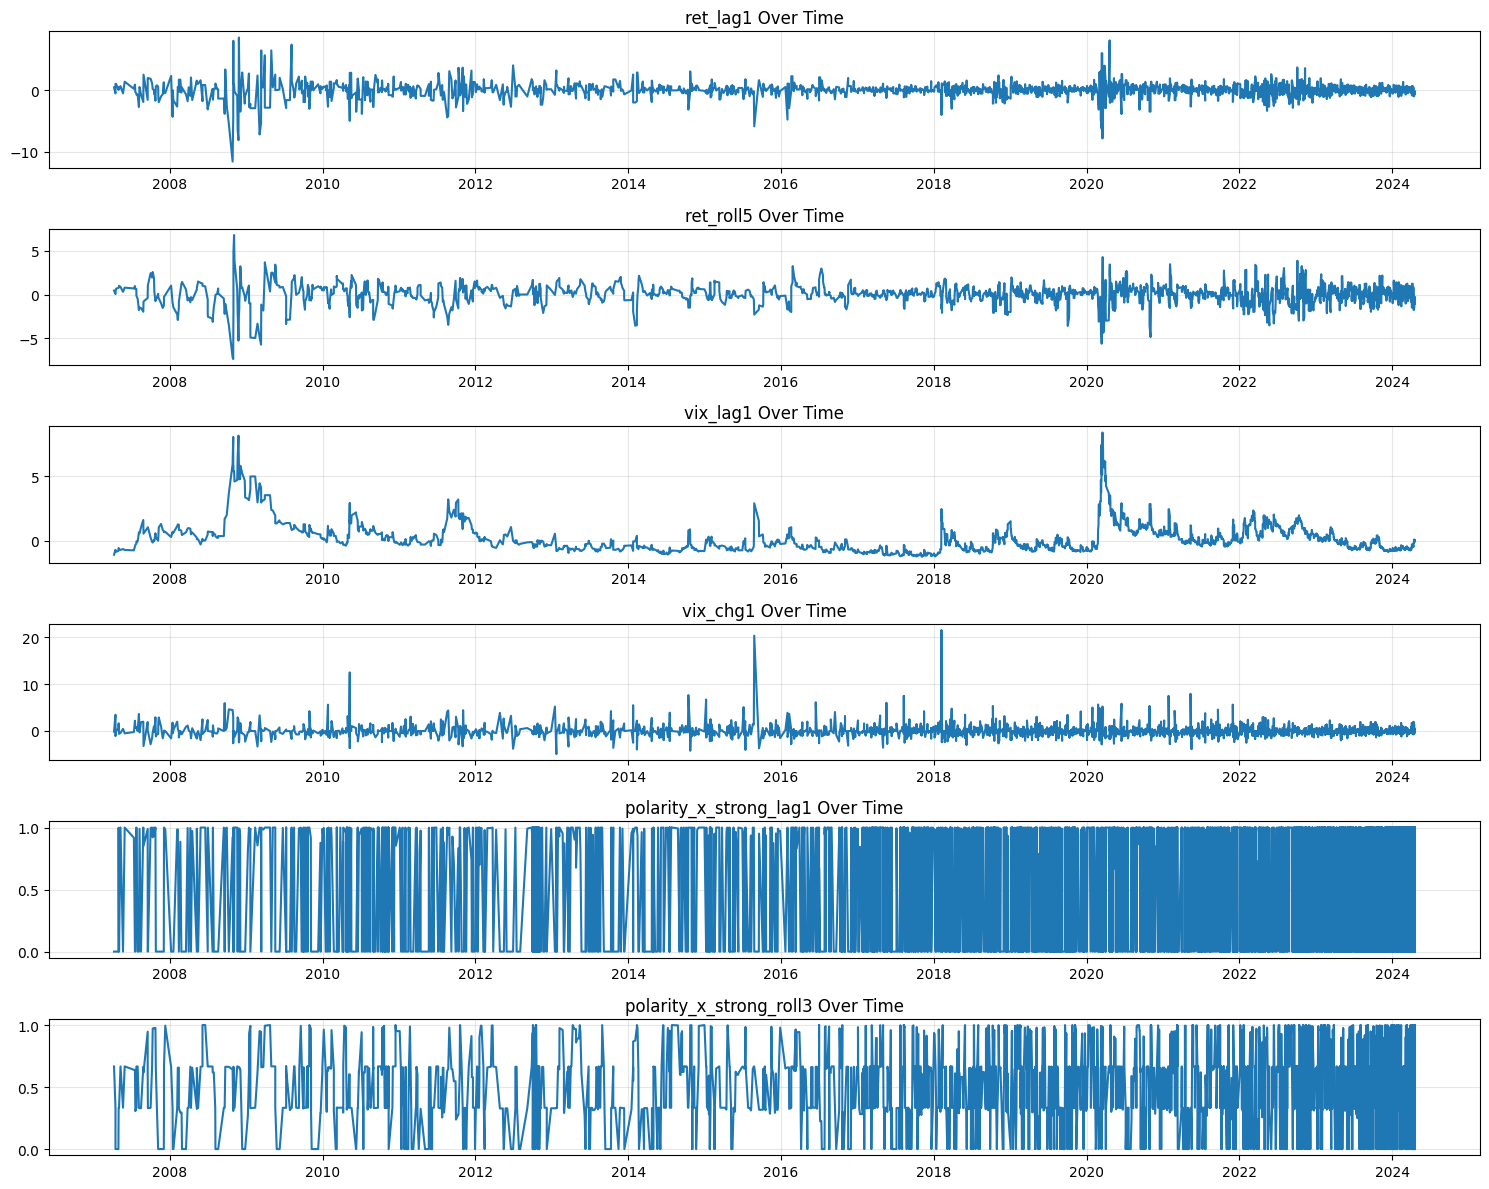

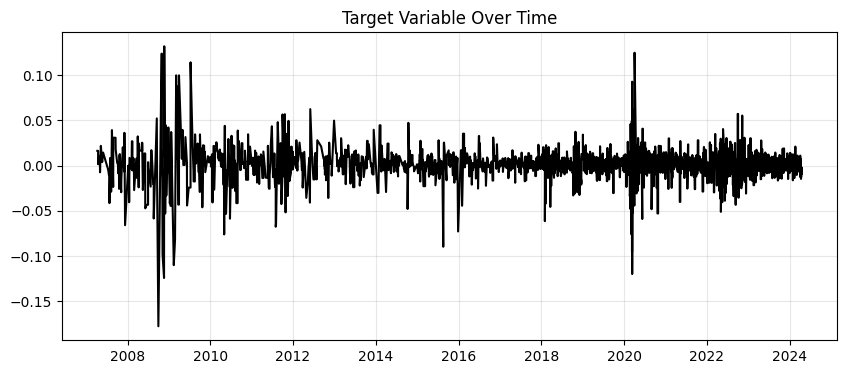

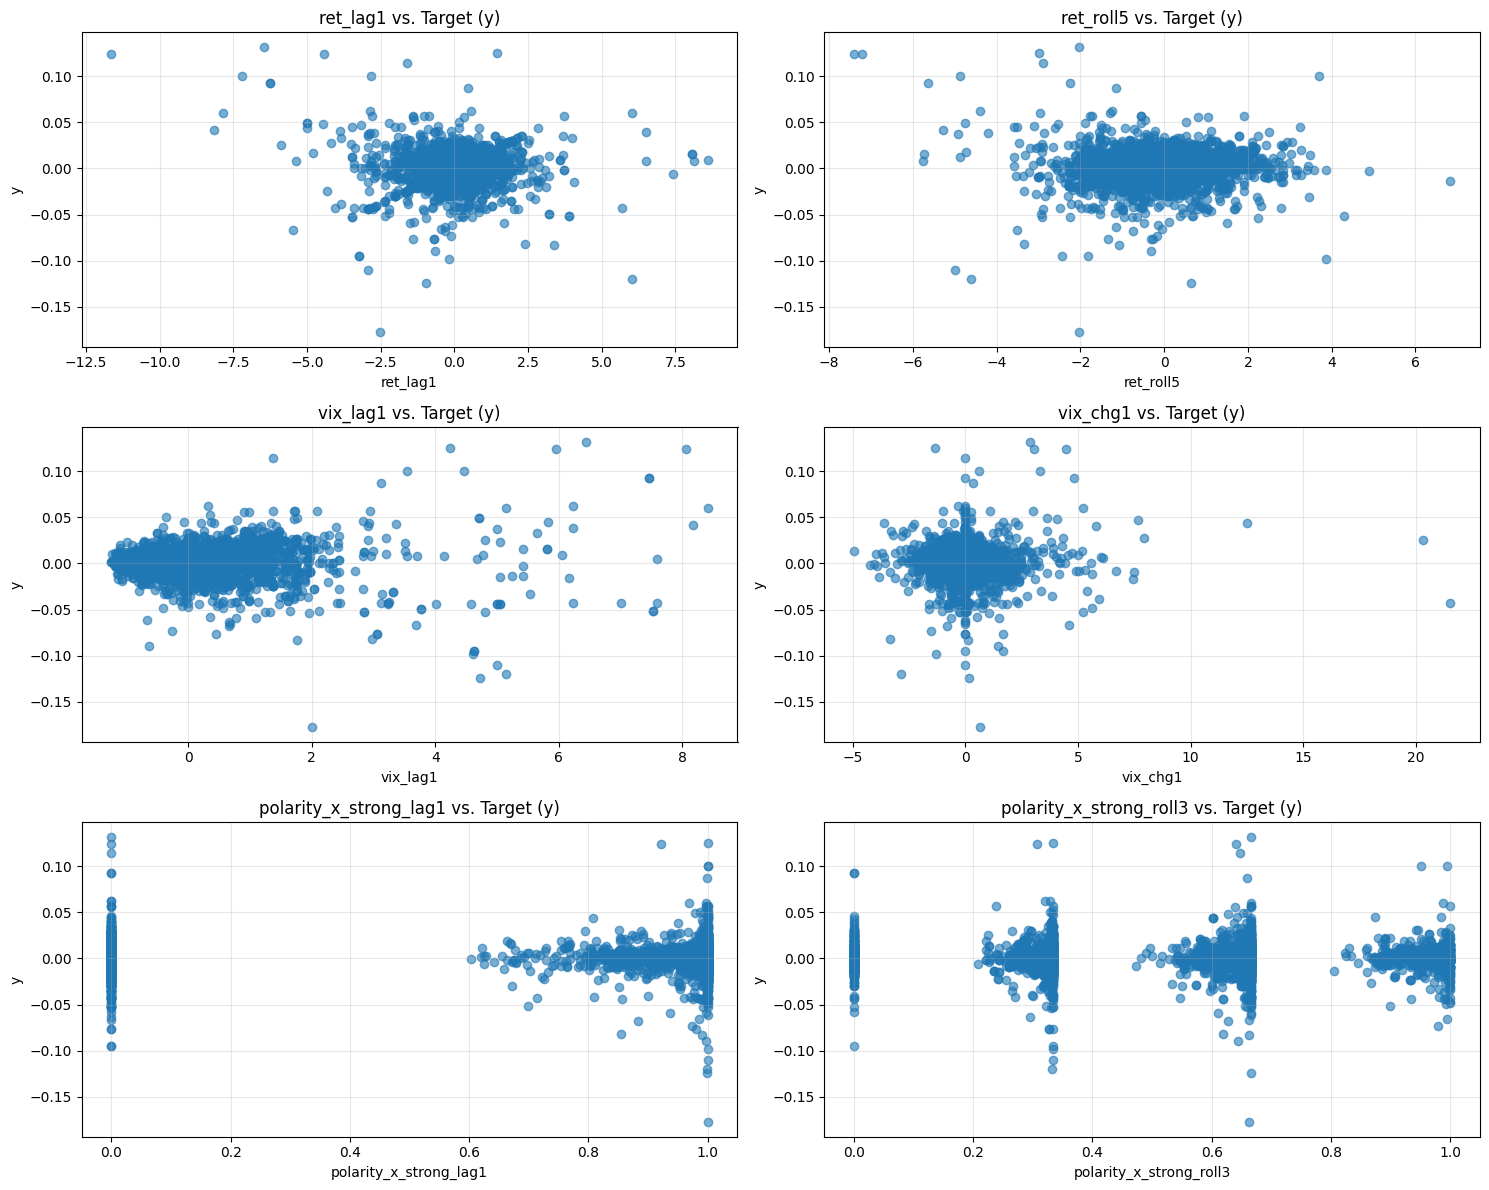

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Define your features and target
feature_cols = ['ret_lag1', 'ret_roll5', 'vix_lag1', 'vix_chg1', 
                'polarity_x_strong_lag1', 'polarity_x_strong_roll3']

# Check the basic info of the data
print(df[feature_cols + ['y']].info())
print(df[feature_cols + ['y']].describe())

# 1. Plot each feature over time
plt.figure(figsize=(15, 12))
for i, col in enumerate(feature_cols):
    plt.subplot(len(feature_cols), 1, i + 1)
    plt.plot(df['date'], df[col])
    plt.title(f'{col} Over Time')
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Plot the target over time
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['y'], label='Target (y)', color='black')
plt.title('Target Variable Over Time')
plt.grid(alpha=0.3)
plt.show()

# 3. Scatter plots: each feature vs. target
plt.figure(figsize=(15, 12))
for i, col in enumerate(feature_cols):
    plt.subplot(3, 2, i + 1)
    plt.scatter(df[col], df['y'], alpha=0.6)
    plt.title(f'{col} vs. Target (y)')
    plt.xlabel(col)
    plt.ylabel('y')
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [61]:
df = pd.read_csv("Savvve.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4165 entries, 0 to 4164
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0.1             4165 non-null   int64  
 1   Unnamed: 0               4165 non-null   int64  
 2   title                    4165 non-null   object 
 3   text                     4165 non-null   object 
 4   label                    4165 non-null   int64  
 5   date                     4165 non-null   object 
 6   p_neg                    4165 non-null   float64
 7   p_neu                    4165 non-null   float64
 8   p_pos                    4165 non-null   float64
 9   sent_polarity            4165 non-null   float64
 10  sent_strong              4165 non-null   int64  
 11  sent_weighted            4165 non-null   float64
 12  ^GSPC_close              4165 non-null   float64
 13  ^VIX_close               4165 non-null   float64
 14  date.1                  